In [23]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import expm, expm_multiply, norm

In [47]:
def RademacherVector(n: int):
    """
        Input:
            n: num of components
        Output:
            vec: random vector from Rademacher distribution
    """
    assert n > 0

    vec = np.random.binomial(1, 1/2, (n, 1))
    vec[vec == 0] = -1

    return vec

def RademacherMatrix(shape):
    """
        Input:
            shape: shape of the matrix
        Output:
            mat: random matrix from Rademacher distribution
    """
    mat = np.random.binomial(1, 1/2, shape)
    mat[mat == 0] = -1

    return mat

def Hutchinson(oracle, n: int, l: int):
    """
        Input:
            oracle: oracle for implicit matrix-vector multiplication with A
            n: size of the matrix A
            l: number of iteration to approximate the trace of the matrix A
        Output:
            approximation: approximation to the trace of A
    """

    assert l >= 0

    approximation = 0
    
    for iter in range(l):
        g = RademacherVector(n)
        approximation += g.T @ oracle(g)
    
    return approximation[0, 0] / l

def HutchinsonATA(oracle1, oracle2, n: int, l: int):
    """
        Input:
            oracle1: oracle for implicit matrix-vector multiplication with A
            oracle2: oracle for implicit matrix-vector multiplication with B
            n: size of the matrix A
            l: number of iteration to approximate the trace of the matrix A.T @ B
        Output:
            approximation: approximation to the trace of the matrix A.T @ B
    """

    assert l >= 0

    approximation = 0
    
    for iter in range(l // 2):
        g = RademacherVector(n)
        approximation += (oracle1(g)).T @ oracle2(g)
    
    return approximation[0, 0] / l

def SquaredFrobenius(oracle, n: int, l: int):
    """
        Input:
            oracle: oracle for implicit matrix-vector multiplication with A
            n: size of the matrix A
            l: number of iteration to approximate the frobenius norm of the matrix A
        Output:
            approximation: approximation to the frobenius norm of A
    """

    assert l >= 0

    approximation = 0
    
    for iter in range(l):
        g = oracle(RademacherVector(n))
        approximation += g.T @ g
    
    return approximation[0, 0] / l

def HutchinsonPlusPlus(oracle, n: int, l: int):
    """
        Input:
            oracle: oracle for implicit matrix-vector multiplication with A
            n: size of the matrix A
            l: number of iteration to approximate the trace of the matrix A
        Output:
            approximation: approximation to the trace of A
    """

    S = RademacherMatrix((n, l // 3))

    Q, _ = np.linalg.qr(oracle(S))

    return np.trace(Q.T @ oracle(Q)) + HutchinsonATA((lambda x: x - Q @ (Q.T @ x)), (lambda x: oracle(x - Q @ (Q.T @ x))), n, l - l // 3)

def HutchinsonPlusPlusWithQ(oracle, n: int, l: int):
    """
        Input:
            oracle: oracle for implicit matrix-vector multiplication with A
            n: size of the matrix A
            l: number of iteration to approximate the trace of the matrix A
        Output:
            approximation: approximation to the trace of A
            Q: matrix appended in the algorithm
    """
    
    S = RademacherMatrix((n, l // 3))

    Q, _ = np.linalg.qr(oracle(S))

    return np.trace(Q.T @ oracle(Q)) + HutchinsonATA((lambda x: x - Q @ (Q.T @ x)), (lambda x: oracle(x - Q @ (Q.T @ x))), n, l - l // 3), Q

def newton(func, deriv, start_point = 0.5, max_iter = 100, toil = 1e-9):
    for _ in range(max_iter):
        new_point = start_point - func(start_point) / deriv(start_point)
        if abs (new_point - start_point) < toil:
            return new_point
        start_point = new_point
    return start_point

In [13]:
def SimpleHutchinson(oracles, n: int, l: int):
    """
        Input:
            oracles: oracles for implicit matrix-vector multiplication with A1, ..., Am
            n: matrix size
            l: number of iteration to approximate the trace of the matrixes A1, ..., Am
        Output:
            approximation: list of approximations to the squared frobenius norm of A1, ..., Am
    """
    assert len(oracles) > 0

    approximation = []
    
    for i in range(len(oracles)):
        approximation.append(SquaredFrobenius(oracles[i], n, l))
    
    return approximation

In [14]:
def DeltaShift(oracles, n: int, l0: int, l: int):
    """
        Input:
            oracles: oracles for implicit matrix-vector multiplication with A1, ..., Am
            n: matrix size
            l0: number of iteration to approximate the trace of the matrix A1
            l: number of iteration to approximate the trace of the other matrixes
        Output:
            approximation: list of approximations to the trace of A1, ..., Am
    """
    assert len(oracles) > 0

    approximation = []
    approximation.append(SquaredFrobenius(oracles[0], n, l0))
    
    for i in range(1, len(oracles)):
        approximation.append(approximation[i - 1]
                             +
                             2 * HutchinsonATA((lambda x: oracles[i - 1](x)),
                                               (lambda x: oracles[i](x) - oracles[i - 1](x)), n, l)
                             +
                             SquaredFrobenius((lambda x: oracles[i](x) - oracles[i - 1](x)),
                                           n, l // 2))
    
    return approximation

def DeltaShiftWorst(oracles, n: int, l0: int, l: int):
    """
        Input:
            oracles: oracles for implicit matrix-vector multiplication with A1, ..., Am
            n: matrix size
            l0: number of iteration to approximate the trace of the matrix A1
            l: number of iteration to approximate the trace of the other matrixes
        Output:
            approximation: list of approximations to the trace of A1, ..., Am
    """
    assert len(oracles) > 0

    approximation = []
    approximation.append(SquaredFrobenius(oracles[0], n, l0))
    
    for i in range(1, len(oracles)):
        approximation.append(approximation[i - 1]
                             +
                             2 * HutchinsonATA((lambda x: oracles[i - 1](x)),
                                               (lambda x: oracles[i](x) - oracles[i - 1](x)), n, l))
    
    return approximation

In [15]:
def DeltaShiftRestart(oracles, n: int, l0: int, l: int, q):
    """
        Input:
            oracles: oracles for implicit matrix-vector multiplication with A1, ..., Am
            n: matrix size
            l0: number of iteration to approximate the trace of the matrix A1
            l: number of iteration to approximate the trace of the other matrixes
        Output:
            approximation: list of approximations to the trace of A1, ..., Am
    """
    assert len(oracles) > 0

    approximation = []
    
    for i in range(len(oracles)):
        if i % q == 0:
            approximation.append(SquaredFrobenius(oracles[i], n, l0))
        else:
            approximation.append(approximation[i - 1]
                             +
                             2 * HutchinsonATA((lambda x: oracles[i - 1](x)),
                                               (lambda x: oracles[i](x) - oracles[i - 1](x)), n, l)
                             +
                             SquaredFrobenius((lambda x: oracles[i](x) - oracles[i - 1](x)),
                                           n, l // 2))
    
    return approximation

def DeltaShiftWorstRestart(oracles, n: int, l0: int, l: int, q):
    assert len(oracles) > 0

    approximation = []
    
    for i in range(len(oracles)):
        if i % q == 0:
            approximation.append(SquaredFrobenius(oracles[i], n, l0))
        else:
            approximation.append(approximation[i - 1]
                             +
                             2 * HutchinsonATA((lambda x: oracles[i - 1](x)),
                                               (lambda x: oracles[i](x) - oracles[i - 1](x)), n, l))
    
    return approximation

In [53]:
def DeltaShiftParametrFree(oracles, oracles_t, n: int, l0: int, l: int):
    assert len(oracles) > 0

    approximation = [0]
    N = 0

    l0 //= 2

    for _ in range(l0):
        g = oracles[0](RademacherVector(n))
        approximation[0] += (g.T @ g)[0, 0]
        z = oracles_t[0](g)
        N += (z.T @ z)[0, 0]

    approximation[0] /= l0
    N /= l0
    variance = 2 / l0 * N

    l //= 4
    
    for i in range(1, len(oracles)):
        z = []
        w = []
        x = []
        y = []
        for j in range(l):
            cur = RademacherVector(n)
            z.append(oracles[i - 1](cur))
            w.append(oracles[i](cur))
            x.append(oracles_t[i - 1](w[j]))
            y.append(oracles_t[i - 1](z[j]))

        A = 0
        B = 0
        C = 0
        for j in range(l):
            A += (x[j].T @ x[j])[0, 0] / l * 4
            B += (x[j].T @ y[j])[0, 0] / l * (-8)
            C += (y[j].T @ y[j])[0, 0] / l

        gamma = newton((lambda x: x**4 * variance + x**3 * (-4 * variance - B) + x**2 * (6 * variance + A + 3 * B + C) + x * (-4 * variance - 2 * A - 3 * B - 2 * C) + (variance + A + B + C)),
                       (lambda x: x**3 * 4 * variance + x**2 * 3 * (-4 * variance - B) + x * 2 * (6 * variance + A + 3 * B + C) + (-4 * variance - 2 * A - 3 * B - 2 * C)))

        print(gamma)

        t = (1 - gamma)**2 * approximation[i - 1]
        for j in range(l):
            t += 2 * ((1 - gamma) * z[j].T @ (w[j] - (1 - gamma) * z[j]))[0, 0] / l

        approximation.append(t)
        variance = (lambda x: x**4 * variance + x**3 * (-4 * variance - B) + x**2 * (6 * variance + A + 3 * B + C) + x * (-4 * variance - 2 * A - 3 * B - 2 * C) + (variance + A + B + C))(gamma)
    
    return approximation

In [49]:
def CheckAlgorithms(oracles, oracles_t, n, correct_ans, title = None):
    """
        Generate graphic with relative error
        Input:
            oracles: list of oracle to compute matrix-vector multiplication
            n: matrix size
            correct_ans: list of the trace of the given matrixes
            title: title of the graphic
        Output:
            -
    """

    l0 = 100
    l = 50

    
    x = np.arange(len(oracles))
    correct_ans = np.array(correct_ans)

    simpl_hutchinson = np.array(SimpleHutchinson(oracles, n, l))
    plt.plot(x, abs(correct_ans - simpl_hutchinson) / max(correct_ans), label="Hutchinson")

    print(1)

    delta_shift = np.array(DeltaShift(oracles, n, l0, l))
    plt.plot(x, abs(correct_ans - delta_shift) / max(correct_ans), label="DeltaShift")

    print(2)

    delta_shift_r = np.array(DeltaShiftWorst(oracles, n, l0, l))
    plt.plot(x,  abs(correct_ans - delta_shift_r) / max(correct_ans), label="DeltaShift Worst")

    print(3)

    delta_shift_p = np.array(DeltaShiftParametrFree(oracles, oracles_t, n, l0, l))
    plt.plot(x,  abs(correct_ans - delta_shift_p) / max(correct_ans), label="DeltaShiftParametrFree")

    print(4)

    delta_shiftpp = np.array(DeltaShiftRestart(oracles, n, l0, l - 50 // 19, 20))
    plt.plot(x, abs(correct_ans - delta_shiftpp) / max(correct_ans), label="DeltaShift Restart")
    # delta_shiftpp_r = np.array(DeltaShiftWorstRestart(oracles, n, l0, l - 50 // 19, 20))
    # plt.plot(x,  abs(correct_ans - delta_shiftpp_r) / max(correct_ans), label="DeltaShift Worst Restart")

    plt.legend()
    plt.xlabel("Time step(i)")
    plt.ylabel("$\\frac{| ||A_i||_F^2 - t_i |}{\max_i ||A_i||_F^2}$")

    if title != None:
        plt.title(title)

    plt.show()

[1332707.9764581206, 1336246.8971447363, 1337922.2034708085, 1336550.9710675753, 1338347.2142619675, 1344054.3980445853, 1346322.735896923, 1350524.062885866, 1349300.83339722, 1349990.2957547663, 1351332.6225000506, 1351789.9867735717, 1350068.5439950135, 1351670.6871465696, 1352035.3390137986, 1353829.726830909, 1357784.0368594823, 1360216.2531896534, 1360494.7851776888, 1361167.6261706986, 1363781.2914489314, 1365181.9253648925, 1368253.8055398273, 1369702.2029672705, 1371835.1856589944, 1373258.9892103425, 1375887.4447377406, 1379169.998362377, 1380836.9321714912, 1382466.3712241163, 1382725.8099074552, 1386977.0750535617, 1387993.025914769, 1388418.52955847, 1388862.5046666253, 1388800.5421099982, 1389973.5628662666, 1391663.4788615613, 1394547.6437261312, 1397294.8670261272, 1398875.405235829, 1401352.6583345653, 1405634.244118702, 1407076.6302004831, 1405048.4277289289, 1406468.1064122864, 1406909.4759688613, 1409471.6738188313, 1409474.9006540098, 1410890.3907038076, 1412486.10

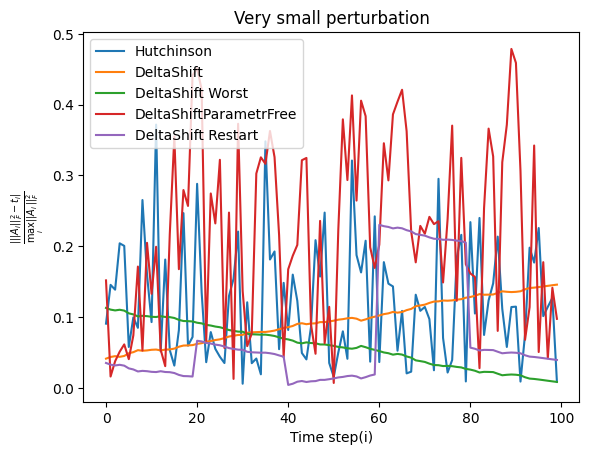

In [51]:
oracles = []
oracles_t = []
correct_ans = []
n = 100

mat = np.random.random((2000, 2000))

for i in range(n):
    oracles.append((lambda x: mat @ x))
    oracles_t.append((lambda x: mat.T @ x))
    correct_ans.append(np.linalg.norm(mat)**2)
    mat += 5 * np.exp(-5) * RademacherVector(2000) @ np.random.random((1, 2000))

print(correct_ans)

CheckAlgorithms(oracles, oracles_t, 2000, correct_ans, "Very small perturbation")

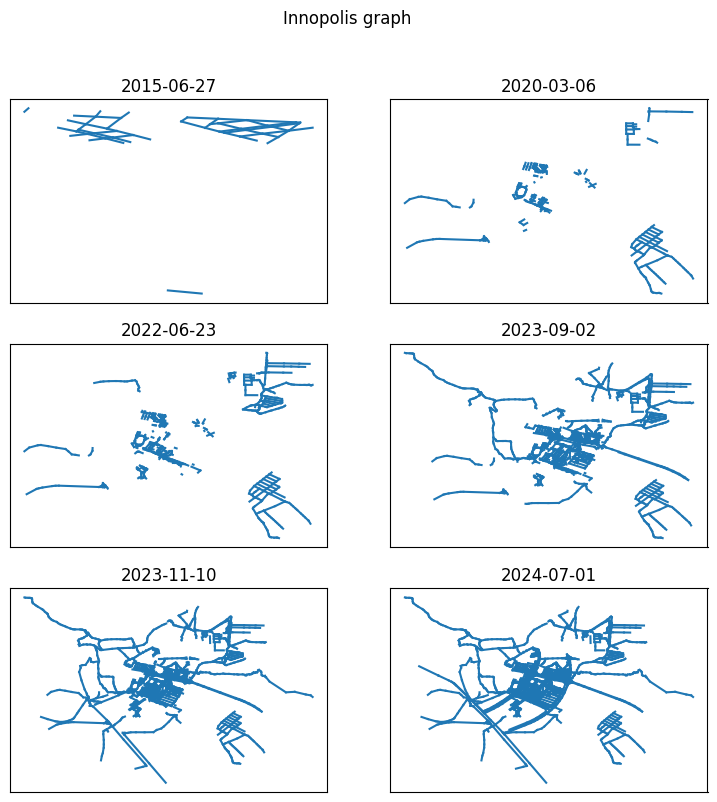

In [52]:
f = open('data/innopolis.graph')

flag = False

fig, ax = plt.subplots(3, 2, figsize=(9, 9))
index_plot = 0

nodes = {}
data = []
nodes_num = {}
cnt = 0

adjency_matrix_innopolis = lil_matrix((3106, 3106))

adjency_array = []

fig.suptitle('Innopolis graph')

times = ['2015-06-10', '2015-06-16', '2015-06-17', '2015-06-27', '2015-08-13', '2016-11-30', '2017-03-05', '2017-04-02', '2017-08-04', '2017-08-21', '2019-05-07', '2019-07-06', '2019-07-24', '2019-09-16', '2019-10-03', '2019-10-23', '2020-03-06', '2020-04-18', '2020-08-27', '2020-11-09', '2021-01-19', '2021-02-01', '2021-03-25', '2021-07-07', '2021-07-09', '2021-10-01', '2021-12-18', '2021-12-20', '2022-05-12', '2022-06-23', '2022-09-17', '2022-12-19', '2023-01-20', '2023-03-13', '2023-03-14', '2023-04-04', '2023-07-05', '2023-07-09', '2023-08-25', '2023-08-30', '2023-08-31', '2023-09-01', '2023-09-02', '2023-09-03', '2023-09-06', '2023-09-07', '2023-09-09', '2023-09-10', '2023-09-13', '2023-09-24', '2023-09-26', '2023-10-22', '2023-10-23', '2023-11-01', '2023-11-02', '2023-11-10', '2023-12-03', '2024-02-17', '2024-02-27', '2024-03-18', '2024-04-22', '2024-06-18', '2024-07-01']
copy_times = times

for line in f.readlines():
    line = line[:-1]
    line = line.split()
    if 'Nodes' in line:
        continue
    if 'Edges' in line:
        flag = True
        continue
    if not(flag):
        nodes[line[0]] = (float(line[1]), float(line[2]))
    else:
        if not(nodes[line[2]] in nodes_num.keys()):
            nodes_num[nodes[line[2]]] = cnt
            cnt += 1
        if not(nodes[line[1]] in nodes_num.keys()):
            nodes_num[nodes[line[1]]] = cnt
            cnt += 1
        
        if len(times) > 3 and line[0] == times[3]:
            ax[index_plot // 2, index_plot % 2].plot(*data)
            ax[index_plot // 2, index_plot % 2].set_title(line[0])
            ax[index_plot // 2, index_plot % 2].get_xaxis().set_visible(False)
            ax[index_plot // 2, index_plot % 2].get_yaxis().set_visible(False)
            index_plot += 1
            if index_plot == 5:
                times = [0, 0, 0, times[len(times) - 1]]
            else:
                times = times[13:]

        adjency_matrix_innopolis[nodes_num[nodes[line[1]]], nodes_num[nodes[line[2]]]] = 1
        adjency_matrix_innopolis[nodes_num[nodes[line[2]]], nodes_num[nodes[line[1]]]] = 1

        data.append((nodes[line[1]][1], nodes[line[2]][1]))
        data.append((nodes[line[1]][0], nodes[line[2]][0]))
        data.append('C0')

        if len(copy_times) > 0 and line[0] == copy_times[0]:
            copy_times = copy_times[1:]
            adjency_array.append(adjency_matrix_innopolis.copy())


plt.show()

/opt/homebrew/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:602: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/opt/homebrew/lib/python3.10/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)


[3111.5243913821673, 3117.0487827643346, 3599.6848514490352, 5254.511277328923, 5768.786174209749, 5977.2429226097765, 6008.4244370204715, 6428.581213407549, 8814.588449045636, 8830.340320816968, 9431.976392956101, 9660.30355863838, 9675.281493063498, 9772.596323653115, 9803.326129849567, 10148.360151465458, 10437.43017150402, 10534.643487426194, 10545.692270190531, 10608.070668593697, 10767.197030896135, 10792.40244571042, 11068.819805423978, 13104.373290268919, 13344.058878800428, 13731.097161773501, 14635.3138679453, 15843.557562091175, 16298.454538221884, 16313.432472647008, 27011.998062790677, 27081.34192952493, 27252.020152446785, 28323.14472525051, 28797.958167637964, 30328.553668844037, 32821.92182881533, 34270.86780134078, 37617.74035211922, 37898.16968230924, 38780.83242746697, 42674.01504482252, 43225.21114577302, 43565.329240046536, 44281.657351503985, 45247.08754222082, 46200.553869137206, 46475.78822246577, 48326.26360027418, 48374.504822144714, 49795.02847218493, 49839.0

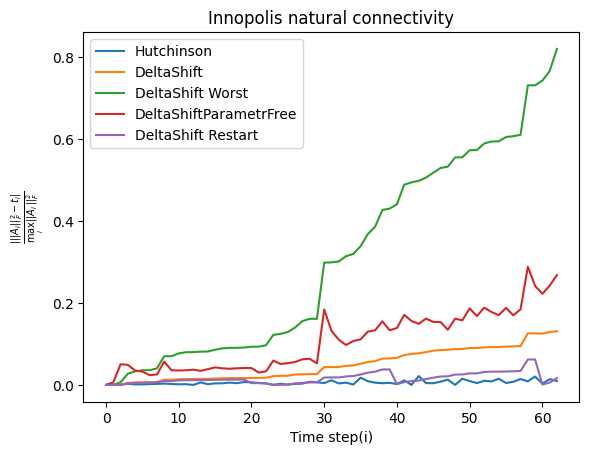

In [56]:
oracles = []
oracles_t = []
for i in range(len(adjency_array)):
    def a(i):
        return (lambda x: expm_multiply(adjency_array[i], x))
    oracles.append(a(i))
    def b(i):
        return (lambda x: expm_multiply(adjency_array[i].T, x))
    oracles_t.append(b(i))


correct_ans = []
for mat, i in zip(adjency_array, range(len(adjency_array))):
    correct_ans.append(norm(expm(mat))**2)

print(correct_ans)

CheckAlgorithms(oracles, oracles_t, adjency_array[0].shape[0], correct_ans, "Innopolis natural connectivity")

In [45]:
def newton(func, deriv, start_point = 0.5, max_iter = 100, toil = 1e-9):
    for _ in range(max_iter):
        new_point = start_point - func(start_point) / deriv(start_point)
        if abs (new_point - start_point) < toil:
            return new_point
        start_point = new_point
    return start_point

In [46]:
newton((lambda x: x**3 + 2/3 * x**2 + 2/3 * x - 1/3),
       (lambda x: 3 * x**2 + 4/3 * x + 2/3))

0.3333333333333333